<a href="https://colab.research.google.com/github/ShibadriM/CrossGen-Analysis/blob/main/CrossGen_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Setting styles for plots
sns.set(style='whitegrid')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/personal_project/smmh.csv')
# Mapping old column names to more manageable ones
column_mapping = {
    '1. What is your age?': 'age',
    '2. Gender': 'gender',
    '6. Do you use social media?': 'use_social_media',
    '8. What is the average time you spend on social media every day?': 'avg_social_media_time',
    '9. How often do you find yourself using Social media without a specific purpose?': 'social_media_without_purpose',
    '10. How often do you get distracted by Social media when you are busy doing something?': 'distracted_by_social_media',
    '12. On a scale of 1 to 5, how easily distracted are you?':  'distracted_scale',
    '13. On a scale of 1 to 5, how much are you bothered by worries?': 'worry_scale',
    '14. Do you find it difficult to concentrate on things?': 'difficulty_concentrating',
    '18. How often do you feel depressed or down?': 'feel_depressed',
    '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?': 'fluctuating_interest',
    '20. On a scale of 1 to 5, how often do you face issues regarding sleep?': 'sleep_issues'
}

# Rename columns in your dataframe
df.rename(columns=column_mapping, inplace=True)

# Verify by displaying the first few rows
df.describe()
print(df.head())

            Timestamp   age  gender 3. Relationship Status  \
0  4/18/2022 19:18:47  21.0    Male      In a relationship   
1  4/18/2022 19:19:28  21.0  Female                 Single   
2  4/18/2022 19:25:59  21.0  Female                 Single   
3  4/18/2022 19:29:43  21.0  Female                 Single   
4  4/18/2022 19:33:31  21.0  Female                 Single   

  4. Occupation Status 5. What type of organizations are you affiliated with?  \
0   University Student                                         University       
1   University Student                                         University       
2   University Student                                         University       
3   University Student                                         University       
4   University Student                                         University       

  use_social_media 7. What social media platforms do you commonly use?  \
0              Yes  Facebook, Twitter, Instagram, YouTube, Discord

In [ ]:
print(df.head())

df.dropna(inplace=True)

df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors ='coerce')
df['hour'] = df['Timestamp'].dt.hour
# Drop rows with invalid ages (e.g., age < 10 or age > 100)
df = df[(df['age'] >= 10) & (df['age'] <= 100)]

            Timestamp   age  gender 3. Relationship Status  \
0  4/18/2022 19:18:47  21.0    Male      In a relationship   
1  4/18/2022 19:19:28  21.0  Female                 Single   
2  4/18/2022 19:25:59  21.0  Female                 Single   
3  4/18/2022 19:29:43  21.0  Female                 Single   
4  4/18/2022 19:33:31  21.0  Female                 Single   

  4. Occupation Status 5. What type of organizations are you affiliated with?  \
0   University Student                                         University       
1   University Student                                         University       
2   University Student                                         University       
3   University Student                                         University       
4   University Student                                         University       

  use_social_media 7. What social media platforms do you commonly use?  \
0              Yes  Facebook, Twitter, Instagram, YouTube, Discord

In [ ]:
# Define a function to categorize age into generations
def categorize_generation(age):
    if age >= 11 and age <= 26:
        return 'Gen Z'
    elif age >= 27 and age <= 42:
        return 'Millennials'
    elif age >= 43 and age <= 58:
        return 'Gen X'
    else:
        return 'Other'

# Apply the function to create a new column 'generation'
df['generation'] = df['age'].apply(categorize_generation)

# Check the distribution of generations
print(df['generation'].value_counts())


generation
Gen Z          342
Millennials     59
Gen X           47
Other            3
Name: count, dtype: int64


In [ ]:
# Group by generation and calculate mean social media usage and mental health indicators
# Create a composite mental health score
df['mental_health_score'] = (df['feel_depressed'] + df['fluctuating_interest'] + df['sleep_issues'] + df['worry_scale'] + df['distracted_by_social_media']) / 5

# Group by generation and calculate mean social media usage and mental health indicators
summary_stats = df.groupby('generation').agg({
    'avg_social_media_time': 'mean',
    'difficulty_concentrating': 'mean',
    'mental_health_score': 'mean'
}).reset_index()



print(summary_stats)

    generation  avg_social_media_time  difficulty_concentrating  \
0        Gen X               1.797872                  2.106383   
1        Gen Z               3.728070                  3.429825   
2  Millennials               2.889831                  3.033898   
3        Other               3.833333                  3.000000   

   mental_health_score  
0             2.280851  
1             3.474854  
2             3.050847  
3             3.800000  


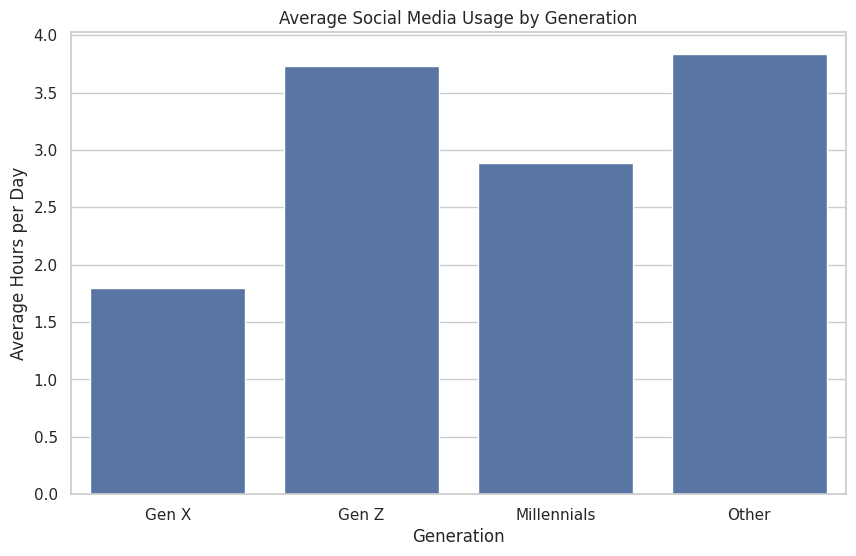

In [ ]:
# Bar plot of social media usage by generation
plt.figure(figsize=(10,6))
sns.barplot(x='generation', y='avg_social_media_time', data=summary_stats)
plt.title('Average Social Media Usage by Generation')
plt.ylabel('Average Hours per Day')
plt.xlabel('Generation')
plt.show()


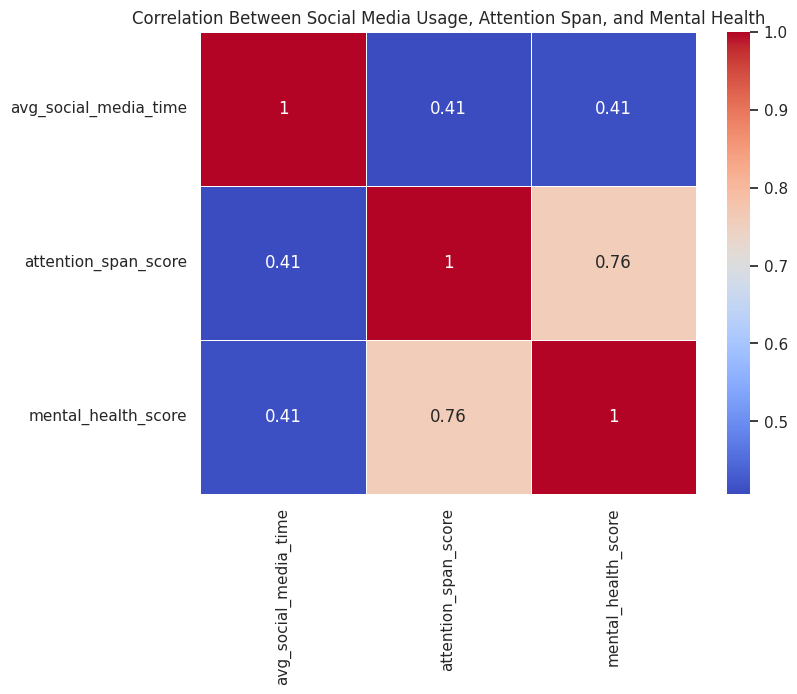

In [ ]:
# Create a correlation matrix
# Check for typos and ensure the column 'distracted_by_social_media' exists
df['attention_span_score'] = (df['distracted_by_social_media'] + df['distracted_scale'] + df['difficulty_concentrating']) / 3

correlation_matrix = df[['avg_social_media_time', 'attention_span_score', 'mental_health_score']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Social Media Usage, Attention Span, and Mental Health')
plt.show()

In [ ]:
# ANOVA: Do generations differ in their social media usage?
anova_model = ols('avg_social_media_time ~ C(generation)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

# ANOVA for mental health score across generations
anova_model_mh = ols('mental_health_score ~ C(generation)', data=df).fit()
anova_table_mh = sm.stats.anova_lm(anova_model_mh, typ=2)

print(anova_table_mh)


                   sum_sq     df          F        PR(>F)
C(generation)  173.223645    3.0  26.317169  1.080867e-15
Residual       980.740879  447.0        NaN           NaN
                   sum_sq     df         F        PR(>F)
C(generation)   63.682286    3.0  28.14424  1.095026e-16
Residual       337.143966  447.0       NaN           NaN


In [ ]:
# Prepare features and target
X = df[['avg_social_media_time', 'age', 'difficulty_concentrating']]  # Independent variables
y = df['mental_health_score']  # Dependent variable

X.fillna(X.mean(), inplace=True)  #Impute missing values with the mean

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a linear regression model
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

# Predict and check the performance
y_pred_reg = regressor.predict(X_test_scaled)

# Calculate R-squared
r_squared = regressor.score(X_test_scaled, y_test)
print(f'R-squared: {r_squared}')

R-squared: 0.49948373085347164


<ipython-input-9-0ac3252855e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  #Impute missing values with the mean


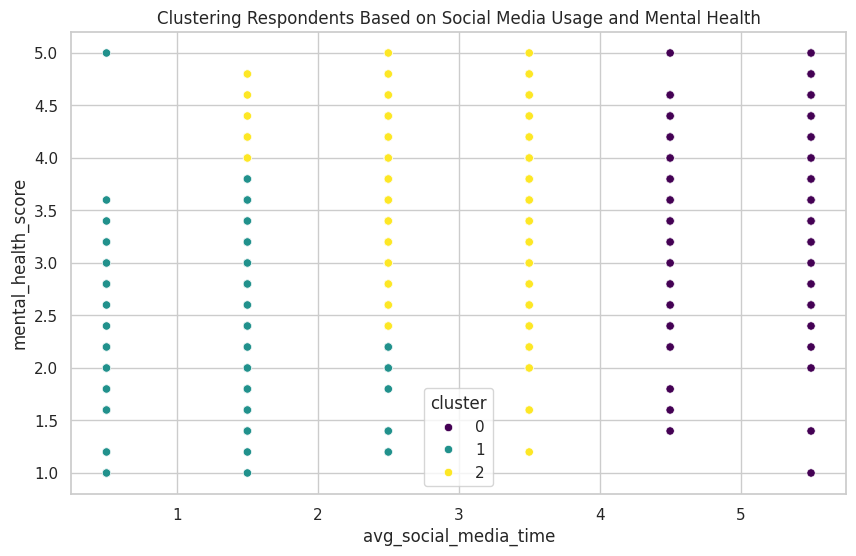

In [ ]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)

# Handle missing values before fitting the model (e.g., imputation)
df[['avg_social_media_time', 'mental_health_score']] = df[['avg_social_media_time', 'mental_health_score']].fillna(df[['avg_social_media_time', 'mental_health_score']].mean())

df['cluster'] = kmeans.fit_predict(df[['avg_social_media_time', 'mental_health_score']])

# Visualize the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='avg_social_media_time', y='mental_health_score', hue='cluster', data=df, palette='viridis')
plt.title('Clustering Respondents Based on Social Media Usage and Mental Health')
plt.show()

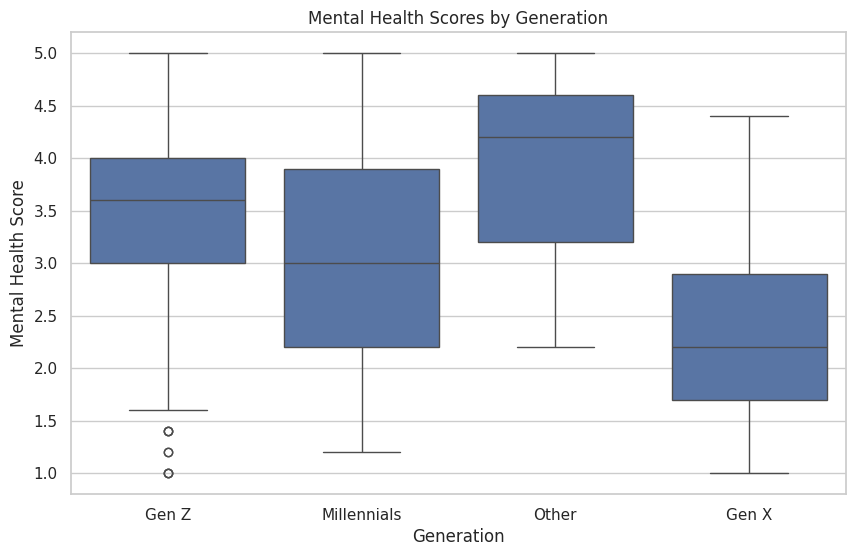

In [ ]:
# Box plot for mental health score across generations
plt.figure(figsize=(10,6))
sns.boxplot(x='generation', y='mental_health_score', data=df)
plt.title('Mental Health Scores by Generation')
plt.ylabel('Mental Health Score')
plt.xlabel('Generation')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['generation_encoded'] = label_encoder.fit_transform(df['generation'])

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



{'Gen X': 0, 'Gen Z': 1, 'Millennials': 2, 'Other': 3}


In [ ]:
X=df[['avg_social_media_time', 'age', 'generation_encoded','difficulty_concentrating']]
y=df['mental_health_score']

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R-squared value:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Perform cross-validation to get a more robust r2 score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
print("Average R-squared from cross-validation:", np.mean(cv_scores))

R-squared value: 0.4649721268354583
Mean Squared Error: 0.4582696900424065
Root Mean Squared Error: 0.6769561950690801
Cross-validated R-squared scores: [0.45054301 0.55193534 0.47507027 0.38698578 0.50200761]
Average R-squared from cross-validation: 0.4733084010679329


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r_squared = model.score(X_test, y_test)
mse=mean_squared_error(y_test, y_pred)
print(f'R-squared: {r_squared}', r_squared)


R-squared: 0.4329800901623527 0.4329800901623527


In [ ]:
from sklearn.linear_model import Ridge, Lasso
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train Ridge and Lasso models
ridge = Ridge(alpha=10)  # Adjust alpha for regularization strength
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength

# Train Ridge regression model
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluate Ridge regression model
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print("Ridge Regression Performance:")
print("R-squared value:", r2_ridge)
print("Mean Squared Error:", mse_ridge)
print("Root Mean Squared Error:", rmse_ridge)

# Cross-validated R-squared scores for Ridge
ridge_cv_scores = cross_val_score(ridge, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores for Ridge:", ridge_cv_scores)
print("Average R-squared from cross-validation (Ridge):", np.mean(ridge_cv_scores))

# Train Lasso regression model
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Evaluate Lasso regression model
r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
print("\nLasso Regression Performance:")
print("R-squared value:", r2_lasso)
print("Mean Squared Error:", mse_lasso)
print("Root Mean Squared Error:", rmse_lasso)

# Cross-validated R-squared scores for Lasso
lasso_cv_scores = cross_val_score(lasso, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores for Lasso:", lasso_cv_scores)
print("Average R-squared from cross-validation (Lasso):", np.mean(lasso_cv_scores))

Ridge Regression Performance:
R-squared value: 0.46612533453323124
Mean Squared Error: 0.4572819281692033
Root Mean Squared Error: 0.6762262403731486
Cross-validated R-squared scores for Ridge: [0.4535283  0.5558416  0.4706513  0.38705386 0.50268938]
Average R-squared from cross-validation (Ridge): 0.4739528900761269

Lasso Regression Performance:
R-squared value: 0.4441743547223801
Mean Squared Error: 0.4760836938688983
Root Mean Squared Error: 0.6899881838617951
Cross-validated R-squared scores for Lasso: [0.47475759 0.550939   0.41565606 0.39333212 0.48898736]
Average R-squared from cross-validation (Lasso): 0.4647344276342583


In [ ]:
from sklearn.linear_model import RidgeCV

alphas = [10**i for i in range(-6, 3)]
# Create a Ridge regression model with cross-validation for alpha selection
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Output the best alpha
print(f"Optimal alpha: {ridge_cv.alpha_}")

# Test the model
test_score = ridge_cv.score(X_test, y_test)
print(f"Test set R^2: {test_score}")

Optimal alpha: 10.0
Test set R^2: 0.46612533453323113


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


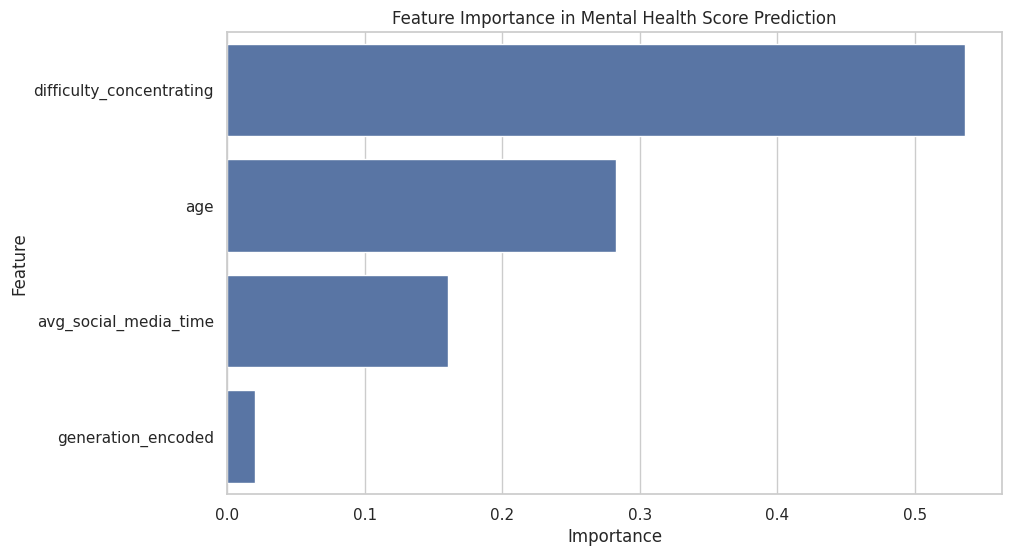

In [ ]:
import seaborn as sns

feature_importances=model.feature_importances_

features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Mental Health Score Prediction')
plt.show()

<ipython-input-19-b9c036c06b20>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2)


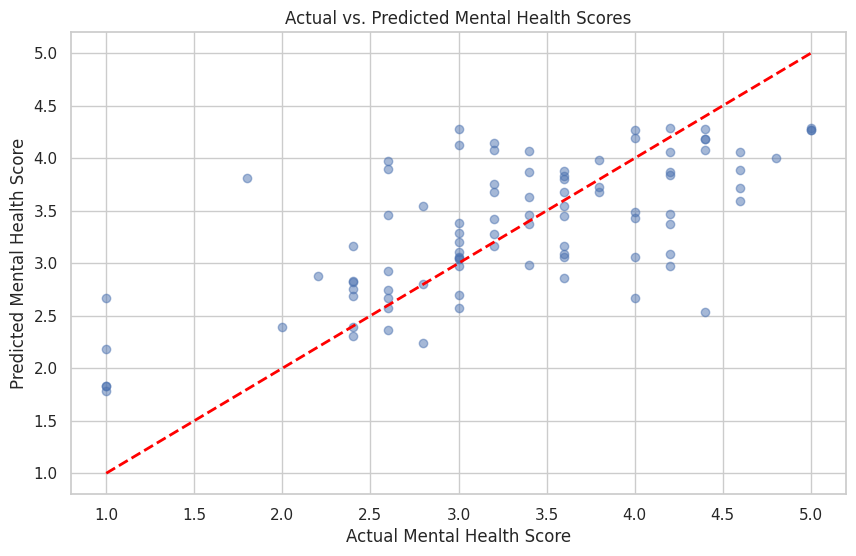

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2)
plt.xlabel('Actual Mental Health Score')
plt.ylabel('Predicted Mental Health Score')
plt.title('Actual vs. Predicted Mental Health Scores')
plt.show()

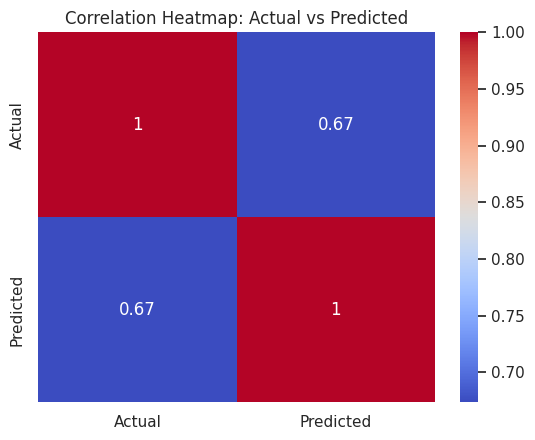

In [ ]:
data = {'Actual': y_test, 'Predicted': y_pred_lasso}
df = pd.DataFrame(data)

# Plot the heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Actual vs Predicted')
plt.show()

<ipython-input-21-b9c036c06b20>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2)


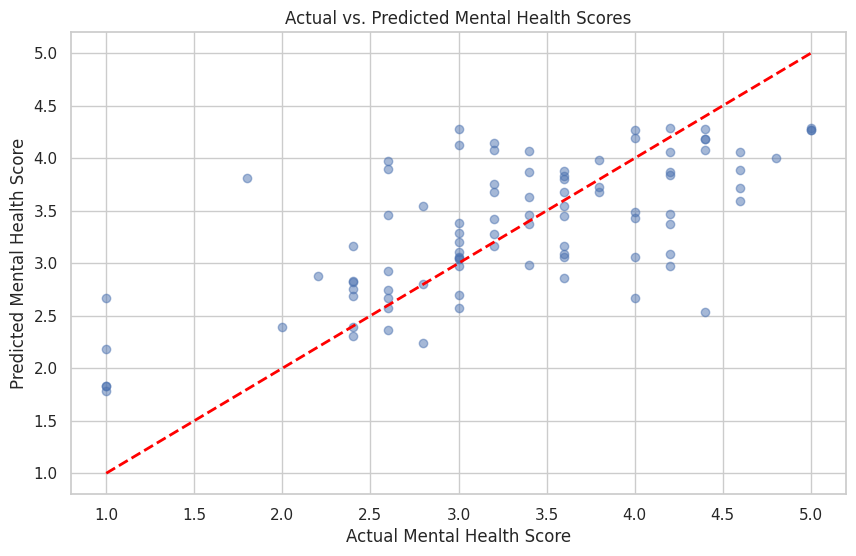

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2)
plt.xlabel('Actual Mental Health Score')
plt.ylabel('Predicted Mental Health Score')
plt.title('Actual vs. Predicted Mental Health Scores')
plt.show()

Text(0, 0.5, 'Residuals')

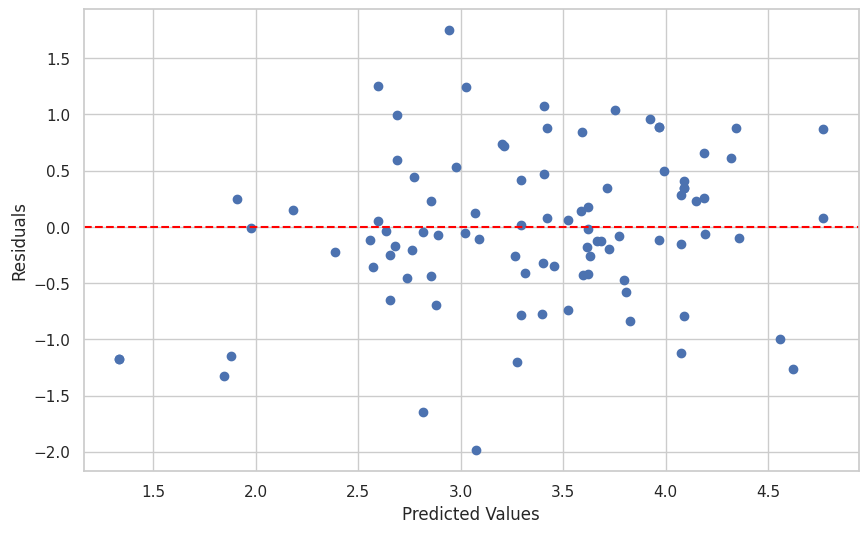

In [ ]:
residuals = y_test - y_pred_lasso
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

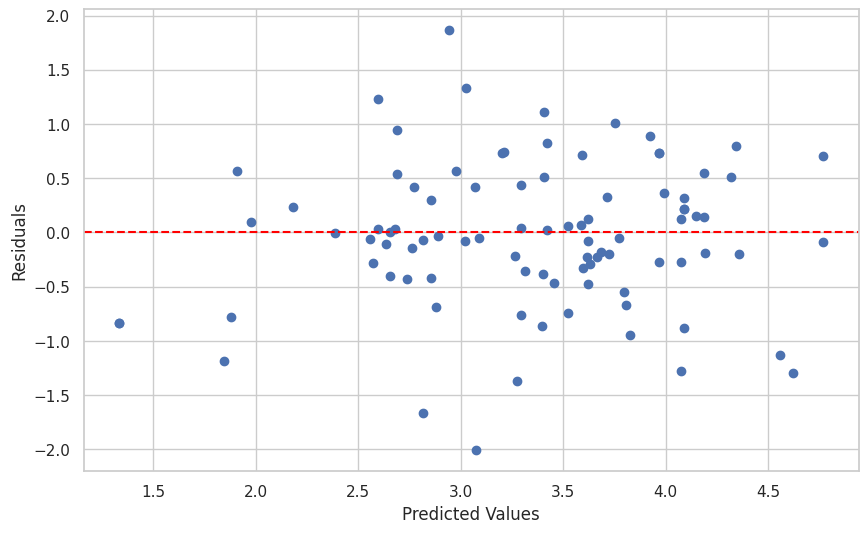

In [ ]:
residuals = y_test - y_pred_ridge
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')